# Notebook Description

This notebook contains the solutions to the data lab "Crypto Investing".

## Environment setup

In [65]:
%matplotlib inline 
# Use %matplotlib ipympl or %matplotlib widget if you want interactive matplotlib plots
#%matplotlib widget 

# reloads modules automatically before entering the execution of code typed at the IPython prompt
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import sys
from datetime import datetime
import matplotlib.dates as mdates
import statsmodels.api as sm


# figure formats

font = {'family':'DejaVu Sans',
        'size': 12}
plt.rc('font', **font) #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.rc.html
#Note you can use python's kwargs dictionary facility to store dictionaries of default parameters. e.g., you can customize the font rc as follows:
#font = {'family' : 'monospace',
#        'weight' : 'bold',
#        'size'   : 'larger'}
#rc('font', **font)  # pass in the font dict as kwargs
#https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Problem3

## 3.1 Data acquisiton

In [2]:
# Data for problem set
DATA_FILE = 'D:/UPenn 24Spring/courses/ds for finance/lab2/20-crypto-investing-mva.csv'

# Display arrays with prec and no scientific notation
np.set_printoptions(precision=4,suppress=True)

# Numerical tolerance for comparisons
TOL = 1.0e-12

# annualizing scale factors
SCALE = 12

Data dictionary:

| Row | Variable | Data type | Description |
|:-----:|:----------|:-----------|:-------------|
| 0 | date | datetime64[M] | Calendar date-end of month | 
| 1 | stock | float | Value-weighted retum to all NYSE, NASDAQ, and AMEXlisted stocks |
| 2 | bond | float | Vanguard Total Bond Market Index Fund |
| 3 | btc | float | Bitcoin USD (BTC-USD) |
| 4 | rf | float | 30-day Treasury bill yield |



In [3]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

df = pd.read_csv('D:/UPenn 24Spring/courses/ds for finance/lab2/20-crypto-investing-mva.csv') 
df

<IPython.core.display.Javascript object>

date   stock      bond       btc      rf
0   2014-10-31  0.0252  0.009386  0.117421  0.0000
1   2014-11-30  0.0255  0.006549 -0.153034  0.0000
2   2014-12-31 -0.0006 -0.001742 -0.320835  0.0000
3   2015-01-31 -0.0311  0.025870  0.169219  0.0000
4   2015-02-28  0.0613 -0.010732 -0.039483  0.0000
..         ...     ...       ...       ...     ...
88  2022-02-28 -0.0229 -0.011272  0.054301  0.0000
89  2022-03-31  0.0304 -0.029133 -0.171806  0.0001
90  2022-04-30 -0.0947 -0.037761 -0.157035  0.0001
91  2022-05-31 -0.0037  0.005776 -0.377688  0.0003
92  2022-06-30 -0.0849 -0.015117  0.179541  0.0006

[93 rows x 5 columns]

## 3.2 Data preparation

### 3.2.1 Explore the raw data

Display top 4 rows in the file

In [4]:
DATA_FILE_1 = '"D:/UPenn 24Spring/courses/ds for finance/lab2/20-crypto-investing-mva.csv"'  

!head -4 $DATA_FILE_1

date,stock,bond,btc,rf
2014-10-31,0.0252,0.00938558039380144,0.11742097403385054,0.0
2014-11-30,0.0255,0.006549415049906804,-0.1530338938256398,0.0
2014-12-31,-0.0006,-0.0017419664501973076,-0.3208345911554661,0.0


Display bottom 6 rows in the file

In [5]:
!tail -6 $DATA_FILE_1

2022-01-31,-0.0625,-0.02026173254933572,0.1223941500332939,0.0
2022-02-28,-0.0229,-0.011272467785812923,0.05430112933051223,0.0
2022-03-31,0.0304,-0.029133293295735885,-0.1718056277838519,0.0001
2022-04-30,-0.0947,-0.037761173806980075,-0.157035240153918,0.0001
2022-05-31,-0.0037,0.005776431143414307,-0.37768830819165067,0.0003
2022-06-30,-0.0849,-0.01511669728249343,0.17954101663669286,0.0006


Display number of lines, words, and bytes in file

In [6]:
x  = !wc $DATA_FILE_1
print(x)
print(type(x)) #Ipython special list to interact with shell. https://ipython.readthedocs.io/en/stable/api/generated/IPython.utils.text.html
wc = x[0].split() #The split() method splits a string into a list. You can specify the separator, default separator is any whitespace.
print(wc) 
print(type(wc))
obs = int(wc[0])-1
print(f"Lines = {wc[0]}")
print(f"Words = {wc[1]}")
print(f"Bytes = {wc[2]}")

['  94   94 6639 D:/UPenn 24Spring/courses/ds for finance/lab2/20-crypto-investing-mva.csv']
<class 'IPython.utils.text.SList'>
['94', '94', '6639', 'D:/UPenn', '24Spring/courses/ds', 'for', 'finance/lab2/20-crypto-investing-mva.csv']
<class 'list'>
Lines = 94
Words = 94
Bytes = 6639


### 3.2.2 Read the raw data into memory and validate the read

- Stock
- RF

In [7]:
# read the date column into a 1-d array
dates = np.genfromtxt(DATA_FILE,usecols=[0],skip_header=1,
                      delimiter=',',dtype=str)

# read remaining columns into a 2-d array
rets_labs = ['stock','bond','btc','rf']
rets  = np.genfromtxt(DATA_FILE,usecols=np.arange(1,len(rets_labs)+1),skip_header=1,
                     delimiter=',',dtype=float)

# Create column labels for rets array
stock,bond,btc,rf = np.arange(len(rets_labs))
stock,bond,btc,rf

(0, 1, 2, 3)

In [8]:
dates_m = np.empty_like(dates,dtype='datetime64[M]')
for i,s in enumerate(dates):
    l = s.split("-")
    print(l)
    if len(l[1]) == 1:
        m = "0"+l[1]
        print(m)
    else:
        m = l[1]
        print(m)
    d = l[0]+"-"+m
    print(d)
    dates_m[i] = np.datetime64(d)    
    
print(dates_m)

['2014', '10', '31']
10
2014-10
['2014', '11', '30']
11
2014-11
['2014', '12', '31']
12
2014-12
['2015', '01', '31']
01
2015-01
['2015', '02', '28']
02
2015-02
['2015', '03', '31']
03
2015-03
['2015', '04', '30']
04
2015-04
['2015', '05', '31']
05
2015-05
['2015', '06', '30']
06
2015-06
['2015', '07', '31']
07
2015-07
['2015', '08', '31']
08
2015-08
['2015', '09', '30']
09
2015-09
['2015', '10', '31']
10
2015-10
['2015', '11', '30']
11
2015-11
['2015', '12', '31']
12
2015-12
['2016', '01', '31']
01
2016-01
['2016', '02', '29']
02
2016-02
['2016', '03', '31']
03
2016-03
['2016', '04', '30']
04
2016-04
['2016', '05', '31']
05
2016-05
['2016', '06', '30']
06
2016-06
['2016', '07', '31']
07
2016-07
['2016', '08', '31']
08
2016-08
['2016', '09', '30']
09
2016-09
['2016', '10', '31']
10
2016-10
['2016', '11', '30']
11
2016-11
['2016', '12', '31']
12
2016-12
['2017', '01', '31']
01
2017-01
['2017', '02', '28']
02
2017-02
['2017', '03', '31']
03
2017-03
['2017', '04', '30']
04
2017-04
['2017',

### Test data read

Compare array rows and cols with raw data

In [9]:
assert dates.shape[0] == obs
assert rets.shape[0] == obs
assert rets.shape[1] == len(rets_labs)

Compare array values with raw data

In [10]:
assert dates_m[0] == np.datetime64("2014-10")
assert dates_m[-1] == np.datetime64("2022-06")
assert np.isclose(rets[0],[0.0252,0.00938558039380144,0.11742097403385054,0.0]).all()
assert np.isclose(rets[-1],[-0.0849,-0.01511669728249343,0.17954101663669286,0.0006]).all()

### 3.2.3 Inspect the data for errors, missing values,etc

Missing values?

In [11]:
assert np.isnan(dates_m).sum() == 0
assert np.isnan(rets).sum() == 0

Are data sorted by date?

In [12]:
assert (dates_m[1:] - dates_m[:-1] == np.timedelta64(1)).all()

Start and end dates of data

In [13]:
print(f"Start date = {dates_m[0]}")
print(f"End date = {dates_m[-1]}")

Start date = 2014-10
End date = 2022-06


### 3.2.4 Ensure a clear understanding of the data

## 3.3 EDA

### 3.3.1 Summary statistics

In [14]:
means = rets.mean(0)
vols  = rets.std(0,ddof=1)
mins  = rets.min(0)
maxs  = rets.max(0)

In [15]:
# mean vector
rets.mean(0)
print(f"      {rets_labs}")
print(f"Avg:  {means}")
print(f"SD:   {vols}")
print(f"Min:  {mins}")
print(f"Max:  {maxs}")

      ['stock', 'bond', 'btc', 'rf']
Avg:  [0.0081 0.0012 0.071  0.0006]
SD:   [0.045  0.011  0.2313 0.0007]
Min:  [-0.1352 -0.0378 -0.3777  0.    ]
Max:  [0.1365 0.028  0.6963 0.0021]


### 3.3.2 Annualized estimate

In [16]:
print(f"      {rets_labs}")
print(f"Avg:  {means*SCALE}")
print(f"SD:   {vols*np.sqrt(SCALE)}")

      ['stock', 'bond', 'btc', 'rf']
Avg:  [0.0977 0.0144 0.8525 0.0071]
SD:   [0.1558 0.0382 0.8011 0.0024]


### 3.3.3 Wealth indices

In [17]:
print(rets)

[[ 0.0252  0.0094  0.1174  0.    ]
 [ 0.0255  0.0065 -0.153   0.    ]
 [-0.0006 -0.0017 -0.3208  0.    ]
 [-0.0311  0.0259  0.1692  0.    ]
 [ 0.0613 -0.0107 -0.0395  0.    ]
 [-0.0112  0.0037 -0.0331  0.    ]
 [ 0.0059 -0.0033 -0.0252  0.    ]
 [ 0.0136 -0.0046  0.1428  0.    ]
 [-0.0153 -0.0101  0.082   0.    ]
 [ 0.0154  0.0076 -0.1918  0.    ]
 [-0.0604 -0.0035  0.0261  0.    ]
 [-0.0307  0.0077  0.3309  0.    ]
 [ 0.0775  0.0001  0.201   0.    ]
 [ 0.0056 -0.0027  0.1411  0.    ]
 [-0.0218 -0.0046 -0.1435  0.0001]
 [-0.0578  0.015   0.1869  0.0001]
 [-0.0009  0.0067 -0.0479  0.0002]
 [ 0.0694  0.0094  0.0758  0.0002]
 [ 0.009   0.0039  0.1853  0.0001]
 [ 0.0177  0.0001  0.2671  0.0001]
 [-0.0007  0.0195 -0.0723  0.0002]
 [ 0.0393  0.0064 -0.0788  0.0002]
 [ 0.0047 -0.0017  0.0595  0.0002]
 [ 0.0023 -0.0008  0.1496  0.0002]
 [-0.0204 -0.0081  0.0638  0.0002]
 [ 0.0485 -0.0264  0.2924  0.0001]
 [ 0.0178  0.0019  0.0069  0.0003]
 [ 0.019   0.0034  0.216   0.0004]
 [ 0.0353  0.0067 -0

In [18]:
x = np.stack([rets[:,0],rets[:,1],rets[:,2],rets[:,3]], axis=-1)

# Construct portfolio series
pvals = 100*(1+x).cumprod(axis=0)

# Construct conforming dates series
d = dates_m

print(pvals)

[[  102.52     100.9386   111.7421   100.    ]
 [  105.1343   101.5996    94.6418   100.    ]
 [  105.0712   101.4227    64.2774   100.    ]
 [  101.8035   104.0465    75.1544   100.    ]
 [  108.044    102.9298    72.1871   100.    ]
 [  106.8339   103.3066    69.7991   100.    ]
 [  107.4642   102.9674    68.0389   100.    ]
 [  108.9258   102.4951    77.7581   100.    ]
 [  107.2592   101.4634    84.1361   100.    ]
 [  108.911    102.2313    67.9993   100.    ]
 [  102.3328   101.8709    69.774    100.    ]
 [   99.1911   102.6513    92.8603   100.    ]
 [  106.8785   102.6606   111.5275   100.    ]
 [  107.477    102.3836   127.2658   100.    ]
 [  105.134    101.9143   108.9991   100.01  ]
 [   99.0572   103.4412   129.3733   100.02  ]
 [   98.9681   104.1349   123.1756   100.04  ]
 [  105.8365   105.109    132.5126   100.06  ]
 [  106.789    105.5152   157.0656   100.07  ]
 [  108.6792   105.5249   199.0231   100.08  ]
 [  108.6031   107.5818   184.6415   100.1   ]
 [  112.8712 

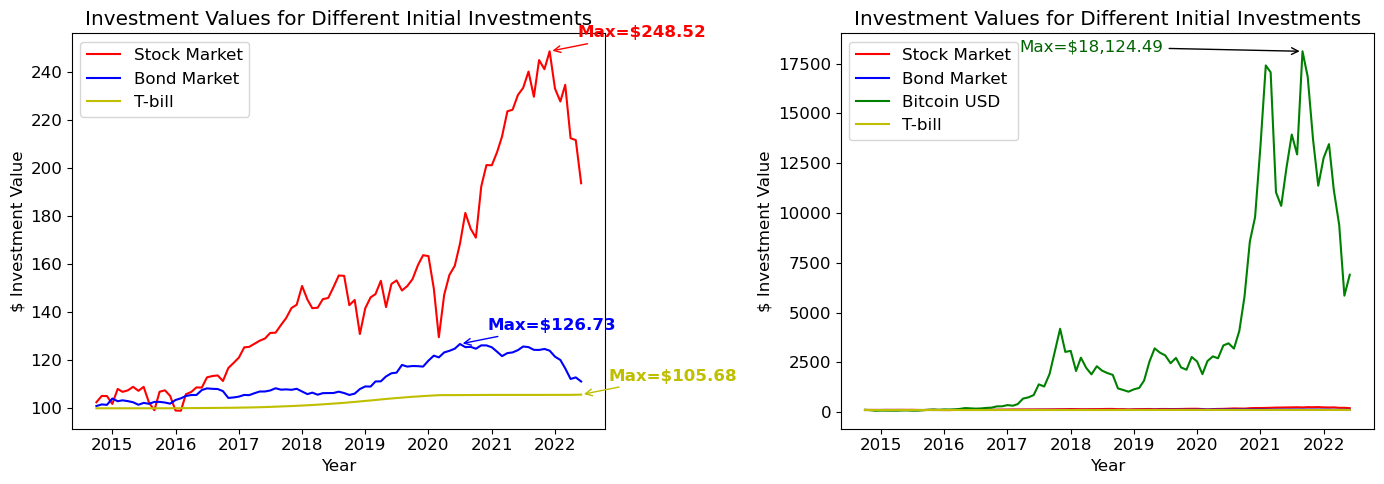

In [68]:


# Assuming pvals, d, and other necessary variables are already defined

# Create a figure and a grid of subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # Adjusted figsize for better display

# Plot 1
w = pvals[:,0]
x = pvals[:,1]
z = pvals[:,3]

axs[0].plot(d, w, color='r', label='Stock Market')
axs[0].plot(d, x, color='b', label='Bond Market')
axs[0].plot(d, z, color='y', label='T-bill')

axs[0].set_title("Investment Values for Different Initial Investments")
axs[0].set_ylabel("$ Investment Value")
axs[0].set_xlabel("Year")
axs[0].legend()

# Annotations for Plot 1
for series, color in zip([w, x, z], ['r', 'b', 'y']):
    max_value = series.max()
    max_date = d[series.argmax()]
    axs[0].annotate(f"Max=${max_value:,.2f}",
                    xy=(mdates.date2num(max_date), max_value), xycoords='data',
                    xytext=(20, 10), textcoords='offset points',
                    weight='bold', color=color,
                    arrowprops=dict(arrowstyle='->', connectionstyle="arc3", color=color))

# Plot 2
w = pvals[:,0]
x = pvals[:,1]
y = pvals[:,2]
z = pvals[:,3]

axs[1].plot(d, w, color='r', label='Stock Market')
axs[1].plot(d, x, color='b', label='Bond Market')
axs[1].plot(d, y, color='g', label='Bitcoin USD')
axs[1].plot(d, z, color='y', label='T-bill')

axs[1].set_title("Investment Values for Different Initial Investments")
axs[1].set_ylabel("$ Investment Value")
axs[1].set_xlabel("Year")
axs[1].legend()

max_value = np.max(y)
max_date = d[np.argmax(y)]

# Convert max_date to Matplotlib date format
max_date_num = mdates.date2num(max_date) if not isinstance(max_date, np.float64) else max_date

# Add annotation for Bitcoin's max value in Plot 2
xytext_position = (-100, 0)  # Adjust as needed for visual appeal

axs[1].annotate(f'Max=${max_value:,.2f}', 
                xy=(max_date_num, max_value), xycoords='data',
                xytext=xytext_position, textcoords='offset points',
                arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle='arc3'),
                horizontalalignment='right', color='darkgreen')


plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure area
plt.show()


### 3.3.4 Histograms

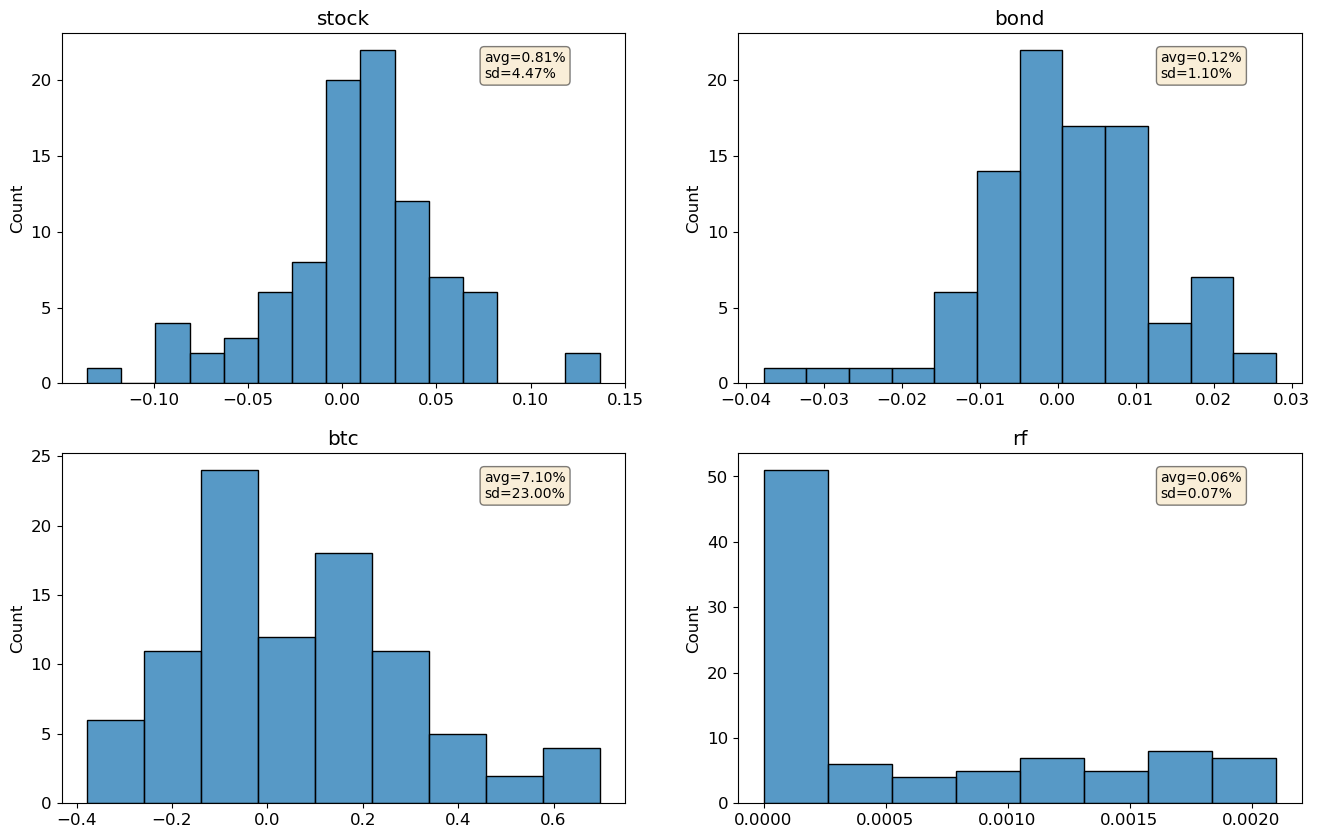

In [54]:

fig,ax=plt.subplots(2,2,figsize=(16,10))
ax=np.ravel(ax)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for i in np.arange(rets.shape[1]):
    ax[i] = sns.histplot(rets[:,i],ax=ax[i])
    ax[i].set_title(rets_labs[i])
    # place a text box in upper right in axes coords
    txtstr = f"avg={rets[:,i].mean():.2%}\nsd={rets[:,i].std():.2%}"
    ax[i].text(0.75, 0.95, txtstr, transform=ax[i].transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    
plt.show()

### Overlay histograms

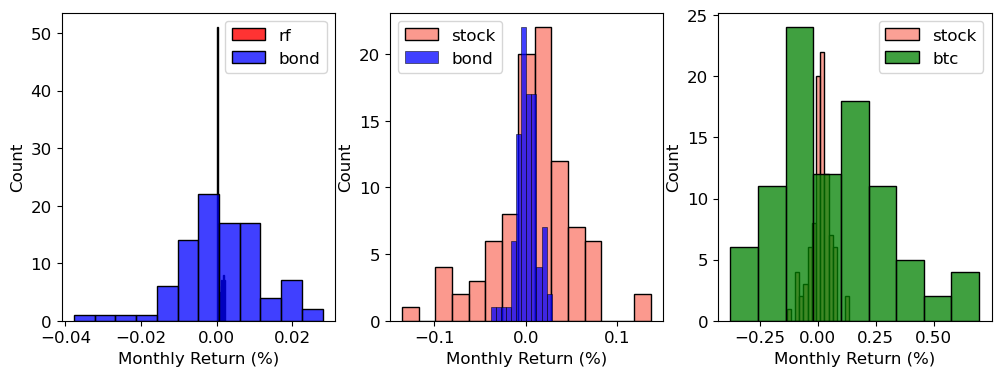

In [51]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))

ax1=sns.histplot(x=rets[:,rf], kde=False, color='red', alpha=0.8, label='rf', ax=ax1)
ax1=sns.histplot(x=rets[:,bond], kde=False, color='blue', label='bond', ax=ax1)
ax1.set_xlabel("Monthly Return (%)")
ax1.legend()

ax2=sns.histplot(x=rets[:,stock], kde=False, color='salmon', alpha=0.8, label='stock', ax=ax2)
ax2=sns.histplot(x=rets[:,bond], kde=False, color='blue', label='bond', ax=ax2)
ax2.set_xlabel("Monthly Return (%)")
ax2.legend()


ax3=sns.histplot(x=rets[:,stock], kde=False, color='salmon', label='stock', ax=ax3)
ax3=sns.histplot(x=rets[:,btc], kde=False, color='green', label='btc', ax=ax3)
ax3.set_xlabel("Monthly Return (%)")
ax3.legend()

plt.show()

### 3.3.5 Time series plots

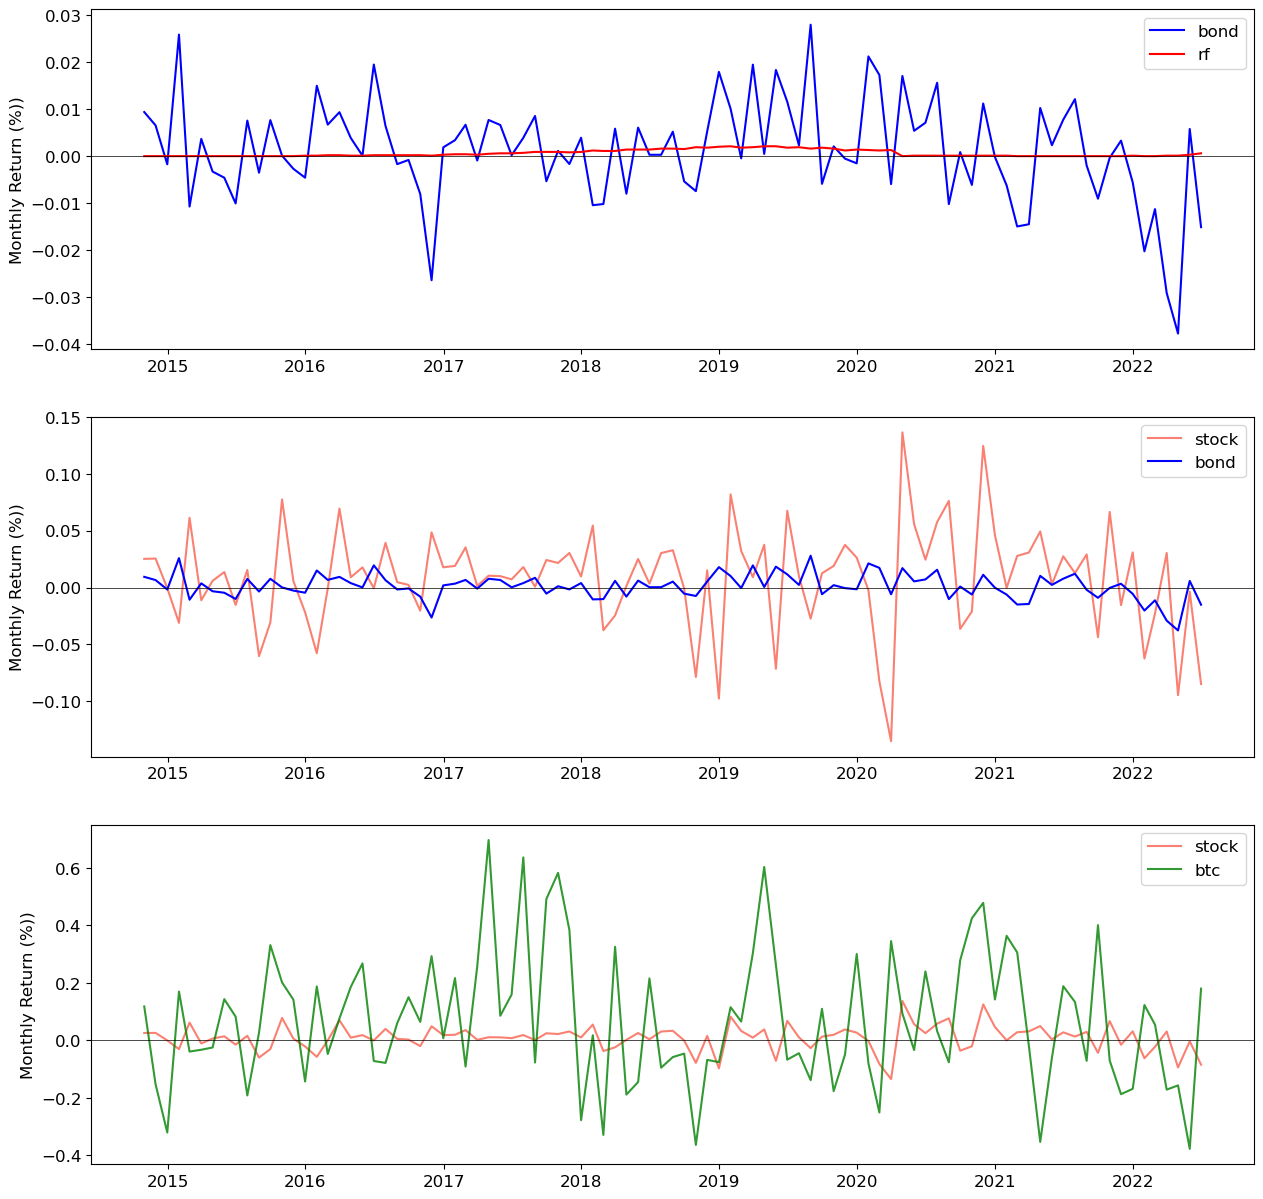

In [105]:
fig,(ax1,ax2, ax3)=plt.subplots(3,1,figsize=(15,15))

dates = pd.to_datetime(dates)


sns.lineplot(x=dates, y=rets[:,bond], label="bond", color='blue', ax=ax1)
sns.lineplot(x=dates, y=rets[:,rf], label="rf", color='red', ax=ax1)
ax1.axhline(0,0,1,color='k',linewidth=.5)
ax1.set_ylabel("Monthly Return (%))")

# FuMark vs. Tbill
sns.lineplot(x=dates, y=rets[:,stock], label="stock", color='salmon', ax=ax2)
sns.lineplot(x=dates, y=rets[:,bond], label="bond", color='blue', ax=ax2)
ax2.axhline(0,0,1,color='k',linewidth=.5)
ax2.set_ylabel("Monthly Return (%))")

sns.lineplot(x=dates, y=rets[:,stock], label="stock", color='salmon', ax=ax3)
sns.lineplot(x=dates, y=rets[:,btc], label="btc", color='green', alpha=0.8, ax=ax3)
ax3.axhline(0,0,1,color='k',linewidth=.5)
ax3.set_ylabel("Monthly Return (%))")

# 改日期坐标

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)


plt.show()



### 3.3.6 Autocorrelation

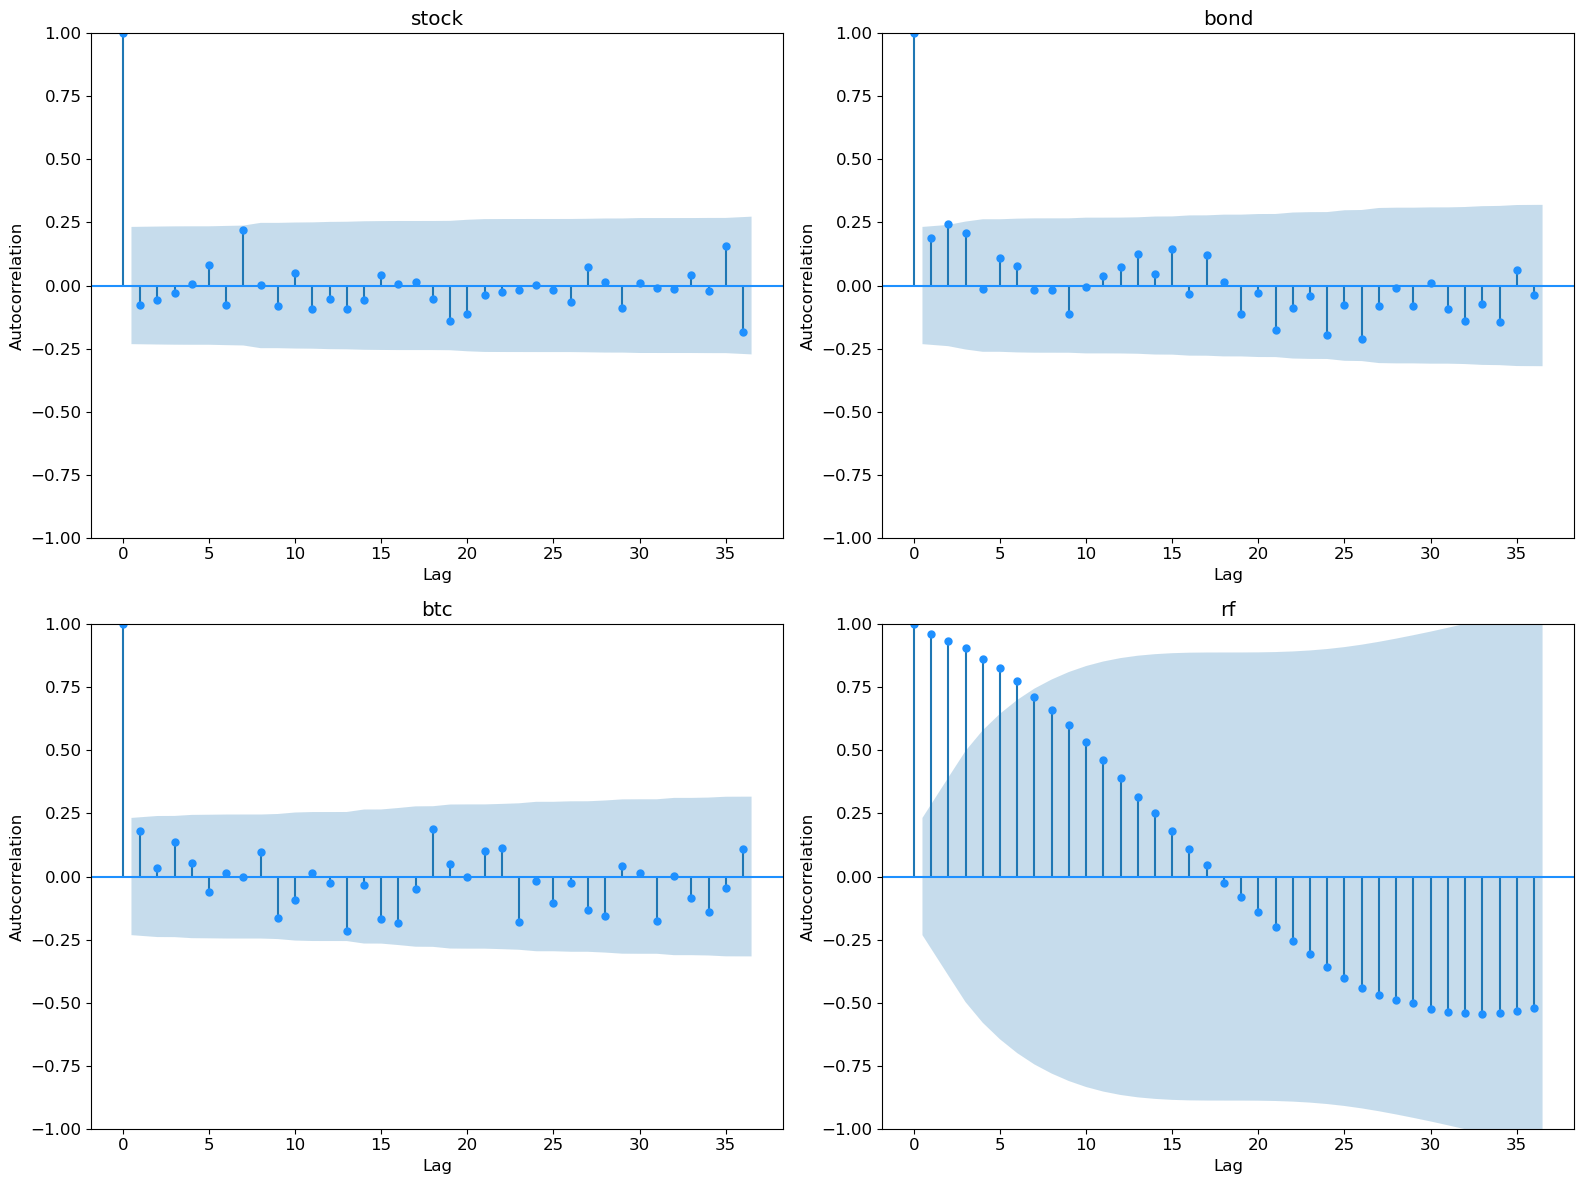

In [66]:
fig, ax = plt.subplots(2,2,figsize=(16,12))
ax = np.ravel(ax)
for i in np.arange(rets.shape[1]):
    m = ~np.isnan(rets[:,i])
    x = rets[m,i]
    sm.graphics.tsa.plot_acf(x, lags=36, alpha=0.025, ax=ax[i], title=rets_labs[i], color='dodgerblue').axes[0]
    ax[i].set_ylabel("Autocorrelation")
    ax[i].set_xlabel("Lag")

plt.tight_layout()  # Prevent axis labels from overlapping
plt.show()

### Correlation

[[ 1.      0.1202  0.0574 -0.1286]
 [ 0.1202  1.     -0.0033  0.2199]
 [ 0.0574 -0.0033  1.     -0.0314]
 [-0.1286  0.2199 -0.0314  1.    ]]


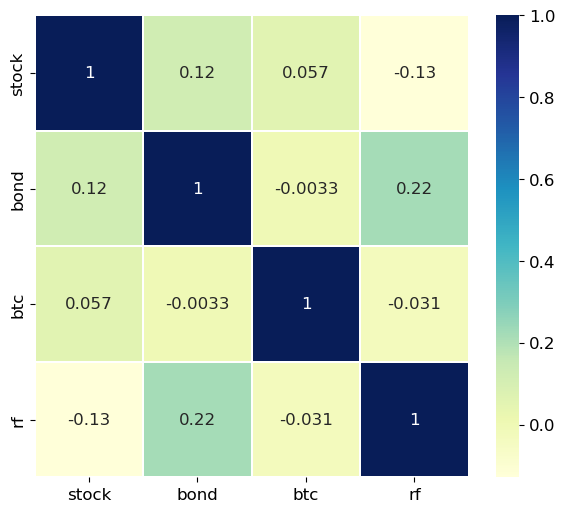

In [67]:
corrmat = np.corrcoef(rets,rowvar=False)
print(corrmat)
f, ax = plt.subplots(figsize =(7, 6)) 
sns.heatmap(corrmat, annot=True, 
            ax = ax, cmap ="YlGnBu", 
            xticklabels=rets_labs,
            yticklabels=rets_labs,
            linewidths = 0.1)

plt.show()

### 3.3.7 Sharpe ratios

In [96]:
xrets  = (rets - rets[:,rf].reshape(-1,1))[:,:-1].mean(0)      # average excess returns.  reshape(-1,1) is a column vector: see https://stackoverflow.com/questions/57962718/reshaping-data-in-numpy-with-1-1-what-does-it-mean
#print( (rets - rets[:,rf].reshape(-1,1)) )
vols   = rets[:,:-1].std(0,ddof=1) #ddof, optional Means Delta Degrees of Freedom. The divisor used in calculations is N - ddof, where N represents the number of elements. By default ddof is zero.
sharpe = xrets/vols

print(f"                       {rets_labs[:-1]}")
print(f"Monthly Sharpe ratios: {sharpe}")
print(f"Annual Sharpe ratios:  {sharpe*np.sqrt(SCALE)}")



                       ['stock', 'bond', 'btc']
Monthly Sharpe ratios: [0.1677 0.0546 0.3046]
Annual Sharpe ratios:  [0.5808 0.189  1.0552]


## 3.4 Advanced analysis

### 3.4.1 Statistics

In [152]:
# means
# mu_stock, mu_bond, mu_btc
mu_1, mu_2, mu_3, mu_rf = means*SCALE
# volatilities
s_1, s_2, s_3          = vols[:3]*np.sqrt(SCALE)
# correlation


corr_stock_bond              = np.corrcoef(rets[:,[stock,bond]],rowvar=False)[1,0]
corr_stock_btc              = np.corrcoef(rets[:,[stock,btc]],rowvar=False)[1,0]
corr_bond_btc              = np.corrcoef(rets[:,[bond,btc]],rowvar=False)[1,0]


#corr_2              = np.corrcoef(rets[:,[msft,duk]],rowvar=False)[0,1]

print(means*SCALE)
print(mu_stock, mu_bond, mu_btc, mu_rf)

print(corr_stock_bond)
#corr_2

[0.0977 0.0144 0.8525 0.0071]
0.09765161290322585 0.014357574283805453 0.852450855193953 0.007135483870967747
0.12024848622703616


### 3.4.2 Mean-variance frontier without Bitcoin

\begin{eqnarray}
    E(r_p) &=& \mu_p = w_1 \mu_1 + w_2 \mu_2 \\
    Var(r_p) &=& \sigma^2_p = w_1^2 \sigma^2_1 + w_2^2 \sigma^2_2 + 2 w_1 w_2 \sigma_1 \sigma_2 \rho_{12} \\
    SD(r_p) &=& \sigma_p = \sqrt{\sigma_p^2}
\end{eqnarray}

where
- $r_p$ is the portfolio return
- $E(r_i) = \mu_i$ is the expected return on asset $i$
- $Var(r_i) = \sigma^2_i$ is the variance of asset $i$
- $SD(r_i) = \sigma_i$ is the standard deviation of asset $i$
- $Corr(r_i,r_j) = \rho_{i,j}$ is the correlation of returns to assets $i$ and $j$

In [157]:
w_1 = np.linspace(-0.5,1.5)         # stock weights. Number of samples to generate is 50 by default (like here).
print(w_1)
w_2 = 1 - w_1                       # bond weights ## THEY NEED TO SUM UP TO 1



pret_mvf = w_1*mu_1 + w_2*mu_2      # portfolio expected return

# portfolio volatility
pvol_mvf = (
    np.sqrt(
        (w_1*s_1)**2
        + (w_2*s_2)**2
        + 2*w_1*w_2*s_1*s_2*corr_stock_bond  
    )
)

corr_12_3 = 

print(pret_mvf)
print(pvol_mvf)


[-0.5    -0.4592 -0.4184 -0.3776 -0.3367 -0.2959 -0.2551 -0.2143 -0.1735
 -0.1327 -0.0918 -0.051  -0.0102  0.0306  0.0714  0.1122  0.1531  0.1939
  0.2347  0.2755  0.3163  0.3571  0.398   0.4388  0.4796  0.5204  0.5612
  0.602   0.6429  0.6837  0.7245  0.7653  0.8061  0.8469  0.8878  0.9286
  0.9694  1.0102  1.051   1.0918  1.1327  1.1735  1.2143  1.2551  1.2959
  1.3367  1.3776  1.4184  1.4592  1.5   ]
[-0.0273 -0.0239 -0.0205 -0.0171 -0.0137 -0.0103 -0.0069 -0.0035 -0.0001
  0.0033  0.0067  0.0101  0.0135  0.0169  0.0203  0.0237  0.0271  0.0305
  0.0339  0.0373  0.0407  0.0441  0.0475  0.0509  0.0543  0.0577  0.0611
  0.0645  0.0679  0.0713  0.0747  0.0781  0.0815  0.0849  0.0883  0.0917
  0.0951  0.0985  0.1019  0.1053  0.1087  0.1121  0.1155  0.1189  0.1223
  0.1257  0.1291  0.1325  0.1359  0.1393]
[0.091  0.0853 0.0796 0.0741 0.0687 0.0635 0.0585 0.0538 0.0495 0.0457
 0.0425 0.04   0.0384 0.0379 0.0384 0.04   0.0425 0.0457 0.0495 0.0538
 0.0585 0.0635 0.0687 0.0741 0.0796 0.0853 0

### Tangency portfolio

In our setup

\begin{eqnarray}
    w_1^{Tang} = \frac{(\mu_1 - r_f)\sigma_2^2 - (\mu_2 - r_f)\sigma_1\sigma_2\rho_{1,2}}
                    {(\mu_1 - r_f)\sigma_2^2 + (\mu_2 - r_f)\sigma_1^2
                        - (\mu_1 - r_f + \mu_2 - r_f)\sigma_1\sigma_2\rho_{1,2}
                    }
\end{eqnarray}

where
- $w_1^{Tang}$ is the portfolio weight on asset 1 in the tangency portfolio.
- $w_2^{Tang} = 1 - w_1^{Tang}$ is the portfolio weight on asset 2 in the tangency portfolio.

In [112]:
## See here for calculation of tangency portfolio
#https://bookdown.org/compfinezbook/introcompfinr/Efficient-portfolios-with-two-risky-assets-and-a-risk-free-asset.html


w_1_tang = (
    ((mu_1-mu_rf)*s_2**2 - (mu_2-mu_rf)*s_1*s_2*corr_stock_bond)
    / (
        (mu_1-mu_rf)*s_2**2 + (mu_2-mu_rf)*s_1**2
        - (mu_1 - mu_rf + mu_2 - mu_rf)*s_1*s_2*corr_stock_bond
    )
)
w_2_tang = 1 - w_1_tang
pret_tang = w_1_tang * mu_1 + w_2_tang * mu_2
pvol_tang = (
    np.sqrt(
        (w_1_tang*s_1)**2
        + (w_2_tang*s_2)**2
        + 2*w_1_tang*w_2_tang*s_1*s_2*corr_stock_bond
    )
)

print("Tangency: Portfolio Weights")
print(" Stock   Bond")
print(f"{w_1_tang:.4f} {w_2_tang:.4f}")
print(f"Expected return: {pret_tang:.4f}")
print(f"Volatility: {pvol_tang:.4f}")
print(f"Sharpe ratio: {(pret_tang - mu_rf)/pvol_tang}")

Tangency: Portfolio Weights
 Stock   Bond
0.5346 0.4654
Expected return: 0.0589
Volatility: 0.0873
Sharpe ratio: 0.593096513893188


### Efficient frontier

In [117]:
alpha = np.linspace(0,3)
pret_eff = alpha * pret_tang + (1 - alpha) * mu_rf
pvol_eff = alpha * pvol_tang

### Visualization

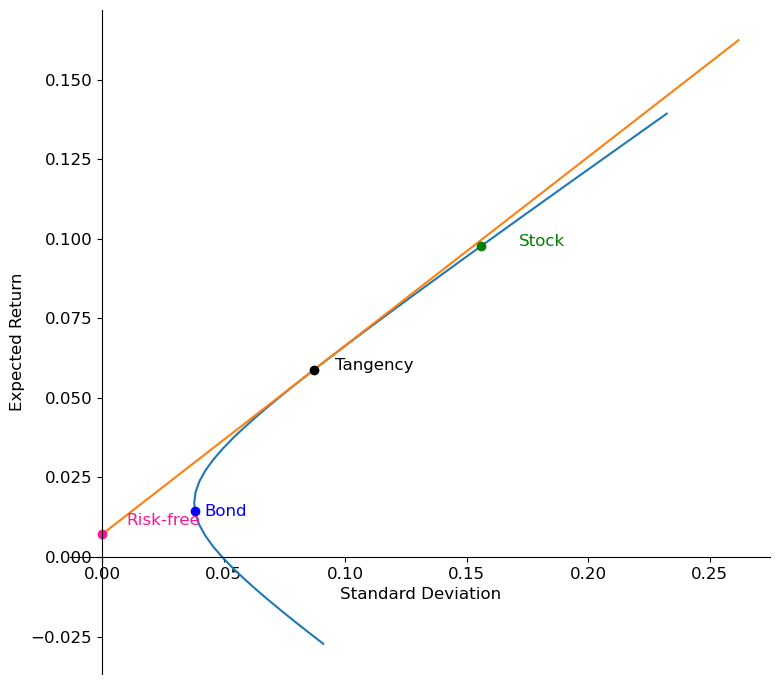

In [119]:
fig,ax=plt.subplots(1,1,figsize=(8,7))
ax.set_ylabel("Expected Return")
ax.set_xlabel("Standard Deviation")

ax.plot(pvol_mvf, pret_mvf)  # mean-var frontier
ax.plot(pvol_eff,pret_eff)   # efficient frontier

ax.plot(pvol_tang, pret_tang, marker="o", color='k')        # Tangency portfolio
ax.text(pvol_tang*1.1, pret_tang, 'Tangency', color='k')
ax.plot(s_1, mu_1, marker="o", color='g')           # stock portfolio
ax.text(s_1*1.1, mu_1, 'Stock', color='g')
ax.plot(s_2, mu_2, marker="o", color='b')             # bond portfoliop
ax.text(s_2*1.1, mu_2*.9, 'Bond', color='b')
ax.plot(0, mu_rf, marker="o", color='deeppink')             # risk-free return
ax.text(0+.01, 0+.01, 'Risk-free', color='deeppink')

# format spines
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.tight_layout()
plt.show()

### 3.4.3 Mean-variance frontier with Bitcoin

\begin{eqnarray}
    E(r_p) &=& \mu_p = \mu_p = w^T \mu
\\
    Var(r_p) &=& \sigma^2_p = w^T \Sigma w \\
    SD(r_p) &=& \sigma_p = \sqrt{\sigma_p^2}
\end{eqnarray}

where
- $w$ is the weight vector  
- $\mu$ is the return vector
- $\Sigma$  is covariance matrix
- $r_p$ is the portfolio return
- $E(r_i) = \mu_i$ is the expected return on asset $i$
- $Var(r_i) = \sigma^2_i$ is the variance of asset $i$
- $SD(r_i) = \sigma_i$ is the standard deviation of asset $i$
- $Corr(r_i,r_j) = \rho_{i,j}$ is the correlation of returns to assets $i$ and $j$

In [164]:
w_1 = np.linspace(-0.5,1.5)         # stock weights. Number of samples to generate is 50 by default (like here).
w_2 = np.linspace(-0.5,1.5)         # bond weights. Number of samples to generate is 50 by default (like here).
w_3 = 1-w_1-w_2                     # bitcoin weights


print(w_3)

mu_vec = rets[:,[stock,bond,btc]].mean(axis=0).reshape(-1,1)
sigma_mat  = np.cov(rets[:,[stock,bond,btc]], rowvar=False)

print(mu_vec)
print(sigma_mat)

[ 2.      1.9184  1.8367  1.7551  1.6735  1.5918  1.5102  1.4286  1.3469
  1.2653  1.1837  1.102   1.0204  0.9388  0.8571  0.7755  0.6939  0.6122
  0.5306  0.449   0.3673  0.2857  0.2041  0.1224  0.0408 -0.0408 -0.1224
 -0.2041 -0.2857 -0.3673 -0.449  -0.5306 -0.6122 -0.6939 -0.7755 -0.8571
 -0.9388 -1.0204 -1.102  -1.1837 -1.2653 -1.3469 -1.4286 -1.5102 -1.5918
 -1.6735 -1.7551 -1.8367 -1.9184 -2.    ]
[[0.0081]
 [0.0012]
 [0.071 ]]
[[ 0.002   0.0001  0.0006]
 [ 0.0001  0.0001 -0.    ]
 [ 0.0006 -0.      0.0535]]


In [172]:
w_1 = np.linspace(-0.5,1.5)         # stock weights. Number of samples to generate is 50 by default (like here).
w_2 = np.linspace(-0.5,1.5)         # bond weights. Number of samples to generate is 50 by default (like here).
w_3 = 1-w_1-w_2          # bond weights. Number of samples to generate is 50 by default (like here).
   




pret_mvf_ = w_12*pret_mvf + w_2*mu_2 + w_3*mu_3      # portfolio expected return

# portfolio volatility
pvol_mvf_ = (
    np.sqrt(
        (w_1*s_1)**2
        + (w_2*s_2)**2
        + (w_3*s_3)**2
        + 2*w_1*w_2*s_1*s_2*corr_stock_bond  
        + 2*w_1*w_3*s_1*s_3*corr_stock_btc
        + 2*w_2*w_3*s_2*s_3*corr_bond_btc
    )
)

print(pret_mvf_)
print(pvol_mvf_)




[ 1.6568  1.5939  1.5307  1.4672  1.4034  1.3394  1.2751  1.2105  1.1456
  1.0805  1.015   0.9493  0.8833  0.8171  0.7506  0.6837  0.6167  0.5493
  0.4816  0.4137  0.3455  0.277   0.2083  0.1393  0.0699  0.0004 -0.0695
 -0.1397 -0.2101 -0.2808 -0.3517 -0.423  -0.4945 -0.5663 -0.6384 -0.7108
 -0.7834 -0.8563 -0.9295 -1.003  -1.0768 -1.1508 -1.2251 -1.2997 -1.3745
 -1.4497 -1.5251 -1.6008 -1.6768 -1.753 ]
[1.5999 1.5346 1.4693 1.404  1.3388 1.2735 1.2083 1.1431 1.0779 1.0127
 0.9475 0.8824 0.8173 0.7523 0.6874 0.6225 0.5578 0.4932 0.4289 0.3649
 0.3016 0.2394 0.1794 0.125  0.0872 0.0902 0.1312 0.1867 0.247  0.3094
 0.3729 0.4369 0.5012 0.5658 0.6306 0.6955 0.7604 0.8255 0.8905 0.9557
 1.0208 1.086  1.1512 1.2164 1.2816 1.3469 1.4122 1.4774 1.5427 1.608 ]


### Visualization

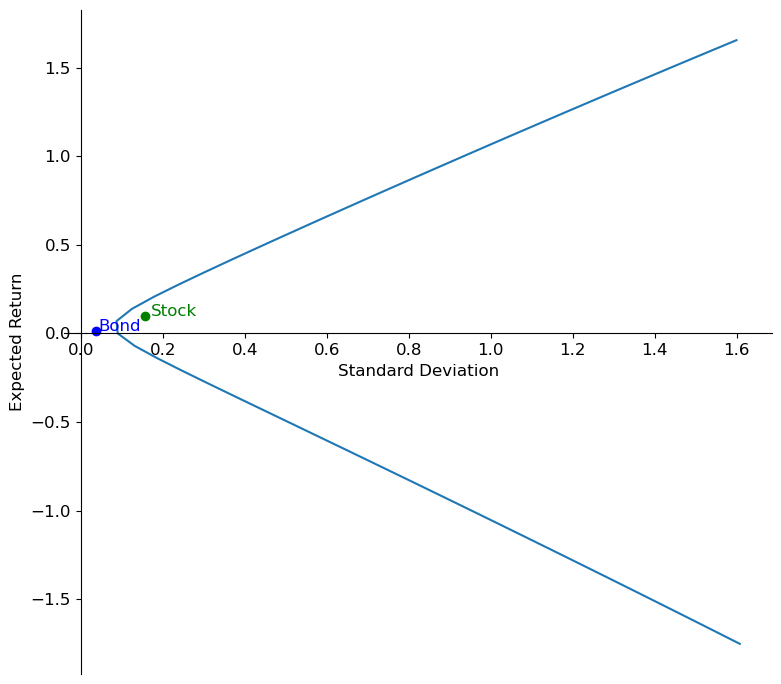

In [174]:
fig,ax=plt.subplots(1,1,figsize=(8,7))
ax.set_ylabel("Expected Return")
ax.set_xlabel("Standard Deviation")

ax.plot(pvol_mvf_, pret_mvf_)  # mean-var frontier
# ax.plot(pvol_eff,pret_eff)   # efficient frontier

# ax.plot(pvol_tang, pret_tang, marker="o", color='k')        # Tangency portfolio
# ax.text(pvol_tang*1.1, pret_tang, 'Tangency', color='k')
ax.plot(s_1, mu_1, marker="o", color='g')           # stock portfolio
ax.text(s_1*1.1, mu_1, 'Stock', color='g')
ax.plot(s_2, mu_2, marker="o", color='b')             # bond portfoliop
ax.text(s_2*1.1, mu_2*.9, 'Bond', color='b')
# ax.plot(0, mu_rf, marker="o", color='deeppink')             # risk-free return
# ax.text(0+.01, 0+.01, 'Risk-free', color='deeppink')

# format spines
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.tight_layout()
plt.show()

## 3.5 Summary and conclusions